## Final Projet Part 1

In [1]:
import pandas as pd
import os.path as osp
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")


# Define paths for the data files
path_cpi_food = osp.join("US CPI Food At Home.xlsx")
path_unemployment = osp.join("US Unemployment rate.xlsx")
path_retail_gas = osp.join("US Gaz price.xlsx")
path_food_inflation = osp.join("US_Food_Inflation_Data.xlsx")
path_ppi = osp.join('./PPI.xls')

# Function to load, prepare, and ensure date ranges are correctly handled
def load_and_prepare_dataset(filepath, skiprows, new_data_col_name):
    # Load the dataset, assuming the first column is dates and the second is the data of interest
    df = pd.read_excel(filepath, skiprows=skiprows, usecols=[0, 1])
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])  # Convert the date column to datetime
    df.set_index(df.columns[0], inplace=True)  # Set the date column as the index
    df.index = df.index.to_period('M').to_timestamp()  # Normalize to the first of the month
    df.columns = [new_data_col_name]  # Rename the data column for clarity
    return df

# Load and prepare each dataset
CPIFood = load_and_prepare_dataset(path_cpi_food, 10, 'CPI_Food_At_Home')
Unemployment = load_and_prepare_dataset(path_unemployment, 10, 'Unemployment_Rate')
RetailGas = load_and_prepare_dataset(path_retail_gas, 6, 'Retail_Gas_Price')
FoodInflation = load_and_prepare_dataset(path_food_inflation, 0, 'Food_Inflation')
ProducerInflation = load_and_prepare_dataset(path_ppi, 192, 'Producer_Inflation')


# Normalize the index to ensure all dates are aligned and in the same format
for df in [CPIFood, Unemployment, RetailGas, FoodInflation, ProducerInflation]:
    df.index = df.index.normalize()

# Merging the DataFrames on their datetime index with attention to alignment
from functools import reduce
data_frames = [CPIFood, Unemployment, RetailGas, FoodInflation,ProducerInflation]
final_data = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), data_frames)

# Display the date range of the merged DataFrame to ensure coverage
print("Date range in the merged DataFrame:", final_data.index.min(), "to", final_data.index.max())

# Display the first few rows to verify correct merging
print("\nMerged DataFrame with Time Series Index and Verified Data Columns:")

#final_data.tail()
final_data.head()

Date range in the merged DataFrame: 2000-10-01 00:00:00 to 2024-02-01 00:00:00

Merged DataFrame with Time Series Index and Verified Data Columns:


,CPI_Food_At_Home,Unemployment_Rate,Retail_Gas_Price,Food_Inflation,Producer_Inflation
2000-10-01,169.0,3.9,1.563,102.0,127.6
2000-11-01,169.2,3.9,1.565,101.8,127.7
2000-12-01,170.2,3.9,1.526,102.4,130.3
2001-01-01,170.4,4.2,1.446,102.9,138.7
2001-02-01,171.6,4.2,1.483,103.2,139.5


In [2]:
#Check the dimensions of the dataset using shape
final_data.shape

(281, 5)

In [3]:
#Get information about the columns, data types, and missing values using 
final_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2000-10-01 to 2024-02-01
Freq: MS
Data columns (total 5 columns):
CPI_Food_At_Home      281 non-null float64
Unemployment_Rate     281 non-null float64
Retail_Gas_Price      281 non-null float64
Food_Inflation        281 non-null float64
Producer_Inflation    281 non-null float64
dtypes: float64(5)
memory usage: 13.2 KB


In [4]:
#Display the data types of each column in the DataFrame.
final_data.dtypes

CPI_Food_At_Home      float64
Unemployment_Rate     float64
Retail_Gas_Price      float64
Food_Inflation        float64
Producer_Inflation    float64
dtype: object

In [5]:
# Generate descriptive statistics summarizing the central tendency, dispersion, and shape of numerical columns in the DataFrame.
# This includes count, mean, standard deviation, minimum, quartiles, and maximum values for each numeric feature.
# It provides a quick overview of the distribution and range of values within each numerical variable.
final_data.describe()

,CPI_Food_At_Home,Unemployment_Rate,Retail_Gas_Price,Food_Inflation,Producer_Inflation
count,281.000000,281.000000,281.000000,281.000000,281.000000
mean,225.061391,5.806406,2.650765,134.685687,212.114217
std,34.184044,1.977127,0.762839,21.520186,57.896059
min,169.000000,3.400000,1.149000,101.800000,124.900000
25%,193.400000,4.400000,2.132000,115.500000,157.300000
50%,231.658000,5.300000,2.630000,135.298000,214.800000
75%,241.581000,6.700000,3.286000,145.172000,241.200000
max,305.788000,14.800000,4.842000,188.055000,382.080000


# Correlation Heat Map

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# This heatmap shows the correlation between variables
sns.heatmap(final_data.corr(), annot=True, cmap='coolwarm')
plt.show()


<Figure size 640x480 with 2 Axes>

In [7]:
from sklearn.linear_model import LinearRegression
train_X = final_data[['Unemployment_Rate','Retail_Gas_Price','Food_Inflation','Producer_Inflation']].values
train_y = final_data['CPI_Food_At_Home'].values

reg = LinearRegression().fit(train_X, train_y)

In [8]:
print("B_0 =",reg.intercept_)
print("B_1 =",reg.coef_[0])
print("B_2 =",reg.coef_[1])
print("B_3 =",reg.coef_[2])
print("B_3 =",reg.coef_[3])


B_0 = 12.015602865663027
B_1 = 0.5234685195399933
B_2 = 1.4567930503114788
B_3 = 1.4651176014113674
B_3 = 0.04155464670839487


# Model

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np 

# Squared independent variables to eliminate non-linear relationships
# Eliminated Food Inflation variable due to collinearity 
final_data['Unemployment_Rate_squared'] = np.square(final_data['Unemployment_Rate'])
final_data['Retail_Gas_Price_squared'] = np.square(final_data['Retail_Gas_Price'])
final_data['Food_Inflation_squared'] = np.square(final_data['Food_Inflation'])


# Fit the OLS regression model
model = ols('CPI_Food_At_Home ~ Unemployment_Rate_squared +Retail_Gas_Price_squared +Producer_Inflation', final_data).fit()


from sklearn.linear_model import LinearRegression
train_X = final_data[['Unemployment_Rate_squared','Retail_Gas_Price_squared', 'Producer_Inflation']].values
train_y = final_data['CPI_Food_At_Home'].values

reg = LinearRegression().fit(train_X, train_y)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       CPI_Food_At_Home   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     283.7
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           3.94e-84
Time:                        13:04:05   Log-Likelihood:                -1193.3
No. Observations:                 281   AIC:                             2395.
Df Residuals:                     277   BIC:                             2409.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

# Residual Plot

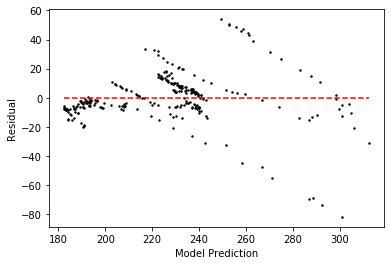

Mean of Residuals: 2.589308759495881e-14


In [10]:
# First, define X and Y Variables
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)
predicted_y = reg.predict(train_X)

residuals = train_y - predicted_y

import matplotlib.pyplot as plt

plt.scatter(predicted_y,residuals, s=2, c='black')


# Line to add dashed horizontal lines
plt.hlines(0,min(predicted_y), max(predicted_y), color='red', linestyles= 'dashed')

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()


print('Mean of Residuals:', residuals.mean())

## Train / Test

In [11]:
from sklearn.linear_model import LinearRegression
train_X = final_data[['Unemployment_Rate_squared','Retail_Gas_Price_squared', 'Producer_Inflation']].values
train_y = final_data['CPI_Food_At_Home'].values

In [12]:
# Splitting the data 70/30 split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_X,train_y,train_size=0.7,random_state=0)

In [13]:
# Train model and assess it against training data
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

In [14]:
# Predicting values
x_tested = reg.predict(x_test)
print(x_tested)

[228.59305845 183.21931848 224.92048072 239.40107845 198.71514054
 243.03020554 225.71527667 228.20457057 297.96987133 202.8106593
 232.39117967 240.58722837 250.57906359 235.88523712 183.44433594
 229.23254613 257.48465206 286.61308131 183.27400331 228.9405017
 199.55568967 232.35508137 217.13434029 214.39385935 225.62262885
 191.71880968 197.11423203 231.91956848 204.49672458 185.8903793
 191.48862483 201.80671382 235.67468605 236.51863224 249.54338508
 187.49676219 238.27743705 231.86121306 189.82554039 236.75982133
 234.90494439 211.58895599 234.10587507 193.47224371 262.75045343
 211.95872654 244.31067073 290.97663299 231.41948657 197.01244775
 225.51749444 183.1125977  190.43008389 232.32061466 229.57506463
 231.42465923 229.52093162 228.79804117 184.17871339 230.33619826
 228.7249487  228.94705778 218.49517753 297.69141888 188.09260749
 208.17938945 227.8432239  237.69481373 239.05473117 237.95989723
 219.3591774  203.58591197 231.85221178 229.94547784 201.88255488
 227.64937619

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy import sqrt

In [18]:
# Stats from Train data
print("R^2:",reg.score(x_train,y_train))
print("Root Mean Squared Error:",sqrt(mean_squared_error(y_train,reg.predict(x_train))))
print("Mean Absolute Error:",mean_absolute_error(y_train,reg.predict(x_train)))

R^2: 0.7516978325607029
Root Mean Squared Error: 17.498833398634495
Mean Absolute Error: 11.647000069178464


In [20]:
# Stats from Test data
print("R^2:",reg.score(x_test,y_test))
print("Root Mean Squared Error:",sqrt(
    mean_squared_error(y_test,reg.predict(x_test))))
print("Mean Absolute Error:",mean_absolute_error(y_test,reg.predict(x_test)))

R^2: 0.7561344089833224
Root Mean Squared Error: 15.650867213780465
Mean Absolute Error: 10.286111861243153


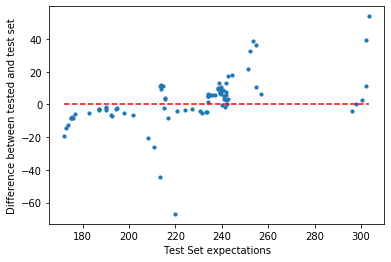

In [30]:
# PLotting The difference of what was expected (y_test) and the calculated results from training (x-tested)
test_differences = y_test - x_tested
plt.scatter(y_test,test_differences, s=10)
plt.hlines(0,min(y_test), max(y_test), color='red', linestyles= 'dashed')

plt.xlabel("Test Set expectations")
plt.ylabel("Difference between tested and test set")
plt.show()
